# An end to end PyTorch workflow

1. Data (prepare and load)
2. Build model
3. Fit model to data (training)
4. Making predictions and evaluating a model (inference)
5. Saving and loading a model


In [1]:
# utils
import numpy
import matplotlib.pyplot as plt

from pathlib import Path

import torch
from torch import nn  # Building blocks for graphs

## 1- Creating a Dataset using the Linear Regression Formula

Data can be almost anything (in machine learning).

- Tabular data (excel, csv, tables in general)
- Images
- Videos
- Audio
- DNA
- Text

The main requirements based on this are to get data into a numerical representation, and build a model to learn patterns in that numerical representation. In this notebook, we'll create some data using the linear regression formula:

$$Y = aX + b$$

where a is the slope of the line, and b is the y axis intercept. These values are also known as "weights" (w) and "bias" (b) respectively.


In [2]:
# Creating known parameters
w = 0.7
b = 0.3

# Create numbers
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(1)  # Adding a dimension
y = w * X + b

In [3]:
# Checking lengths
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

Just as a recap on the importance of dataset splitting, the model shouldn't train and be tested on the same data, it is a biased vision into the generalization ability of a model.

In order to check the validity of a model, we split the data into training and test sets and expose the model to them at different times, thus ensuring that the model is able to deal not only with the data it already knows (training data), but also the data it has never encountered before (test data).


In [4]:
# Splitting data into training and test sets
train_split = int(0.8 * len(X))  # Using 80% of the data for training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
# Function for visualizing data
def plot_model_data(train_data, train_labels, test_data, test_labels, predictions=None):
    '''
    Plots training data, test data and compares predictions (if not none).
    '''

    plt.figure(figsize=(10, 7))

    # Training data
    plt.scatter(train_data, train_labels, c='r', s=4, label='training_data')

    # Testing data
    plt.scatter(test_data, test_labels, c='b', s=4, label='testing_data')

    # Predictions (if any)
    if predictions != None:
        plt.scatter(test_data, predictions, c='g', s=4, label='predictions')

    # Showing functions
    plt.legend()
    plt.show

## 2- Building a model


### 2.1- Creating a model to predict linear regression

Building a simple model to predict the training data


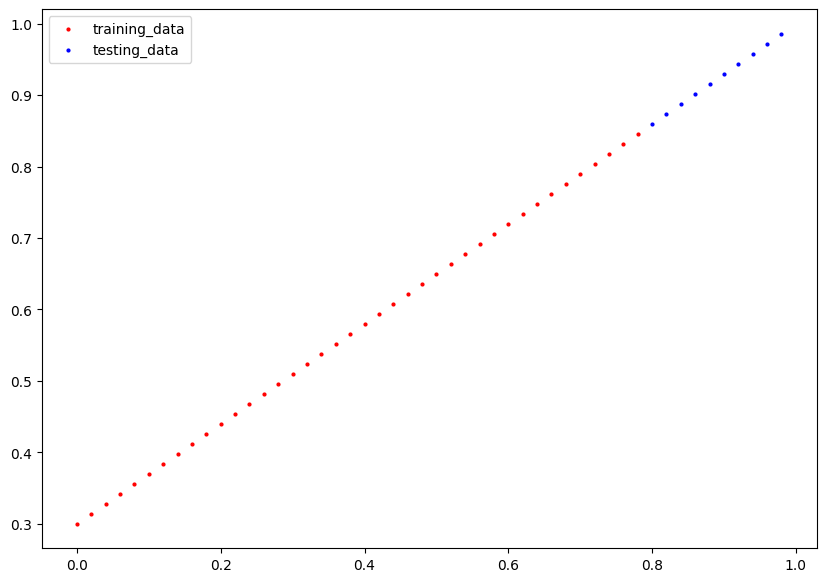

In [6]:
# Plotting current data
plot_model_data(X_train, y_train, X_test, y_test)

### 2.2- Building a model with PyTorch

The model starts with random values, looks at random data, and adjusts the values to get closer to the ideal values. This is done by using mostly two algorithms:

1. Gradient descent
2. Backpropagation

#### PyTorch model building essentials

PyTorch provides the following for helping to build neural networks.

- `torch.nn` contains all of the buildings for computational graphs (essentially a series of computations executed in a particular way).

- `torch.nn.Parameter` what parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these automatically.

- `torch.nn.Module` the base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method to be implemented.

- `torch.optim` Contains various optimization algorithms (tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss).

- `torch.utils.data.Dataset` represents a map between key (label) and sample (features) pairs of your data.

- `torch.utils.data.DataLoader` creates a Python iterable over a torch Dataset (allows iteration over the data).


#### Defining model

The model will represent the following formula:

$$Y = aX + b$$


In [7]:
# Creating linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()  # Initializing parent class

        # Defining  Model's weights
        self.weights = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float32)
        )

        # Defining Model's bias
        self.bias = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float32)
        )

    # Defining method for computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

#### Checking uninitialized parameters


In [8]:
# Looking at the parameters

# Creating random seed
torch.manual_seed(42)

# Creating an instance of the model
model_0 = LinearRegressionModel()

# Checking parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# Listing named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions with untrained model

The idea here is to use the untrained model and see how well it can predict `y_test` based on `X_test`. Since the model isn't trained, the data will simply go through the forward method (only forward-propagation).

We use `with torch.inference_mode()` as a context manager. It disables gradient tracking, meaning PyTorch deals with less data, processing predictions faster.

As an alternative, you can use `<model_name>(<test_data>)` and it'll work the same, but it has gradient tracking, meaning it deals with more data, processing predictions slower.

Another alternative, that works closer to `inference_mode()` is to substitute this for `no_grad()`, both work very similarly, but the first is faster.

In PyTorch predictions are done with `torch.inference_mode()`.


In [10]:
# Making predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

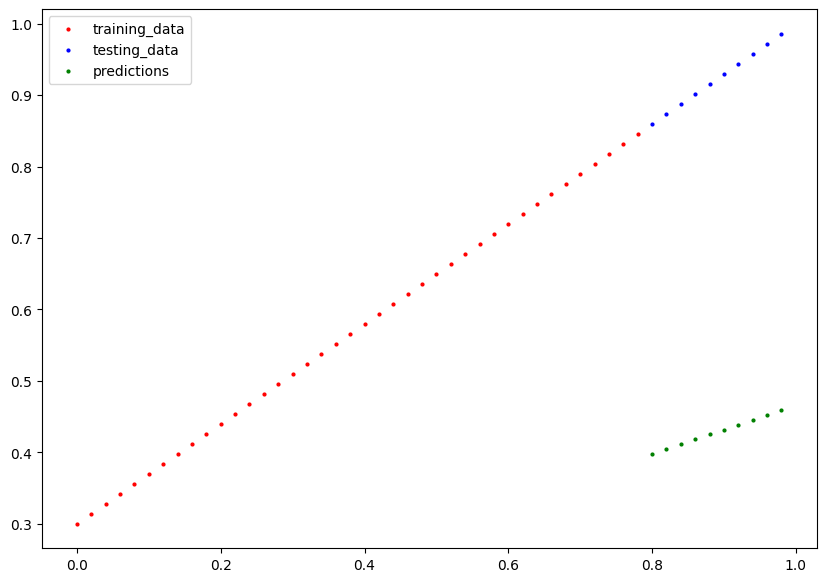

In [11]:
# Plotting predictions
plot_model_data(X_train, y_train, X_test, y_test, y_preds)

## 3- Training model

The idea of training a model is to move from _unknown_ parameters to _known_ parameters. In other words, from a poor representation of the data to a better one. One way to measure how poor or how wrong your model's predictions are, is to use a loss function (cost functions, or criterion).

**_Loss functions_** are functions to measure how wrong a model's predictions are to the ideal outputs, with values of `0` being ideal.

Another essential part of training deep learning models, are optimizers. **_Optimizers_** are functions that take the loss of a model into account and adjusts the model's parameters (weights and bias) for a better representation of the data, by improving the value of the loss function.

To set these up, you instantiate both your desired loss and optimizer. The optimizer needs to receive the model's parameters (`params`), you can also add a specified learning rate (`lr`) which is a hyperparameter that tells the optimizer how much each step is scaled.

In PyTorch, for training we use two loops, a training loop and a testing loop. For the training loop there are a few steps to take:

1. Loop through the data.
   1. the loop itself `for epoch in range(epochs):`.
2. Set the model for training mode.
   1. `<model_name>.train()`
3. Forward pass (involves data moving through the model's `forward()` functions) to make predictions on data.
   1. `<model_name>(<training_data>)`.
4. Calculate the loss.
   1. `<loss_function>(<label_predictions>, <actual_labels>)`.
5. Reset the gradient, since each step accumulates the gradient from the past step (it basically accumulates for increased efficiency and more control).
   1. `optimizer.zero_grad()`
6. Backpropagation to calculate the gradients of each of the model's parameters with respect to the loss.
   1. `optimizer.backward()`
7. Gradient descent uses the optimizer to adjust the model's parameters and improve the loss.
   1. `optimizer.step()`

Epochs set the number of times the data will loop (how many iterations of training/testing).

To train a model, you need to set the model to training mode `<model_name>.train()`, it sets all parameters that require gradients to require gradients.

To test a model, you need to set the model to testing mode `<model_name>.eval()`, turns of gradient tracking


In [12]:
# Setting up a loss function
loss_fn = nn.L1Loss()

# Setting up an optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01,
)

In [13]:
# Setting up number of loops
epochs = 180

# Saving values for tracking
epoch_count = []
loss_values = []
test_loss_values = []


# Looping through the data
for epoch in range(epochs):
    # Saving epoch
    epoch_count.append(epoch)

    # Setting model to training mode
    model_0.train()

    # Forward pass
    y_pred = model_0(X_train)

    # Calculating and saving loss
    loss = loss_fn(y_pred, y_train)
    loss_values.append(loss)

    # Resetting gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Gradient Descent
    optimizer.step()

    # Setting up testing mode
    model_0.eval()

    # Evaluating model
    with torch.inference_mode():
        # Doing forward pass
        test_pred = model_0(X_test)

        # Calculate loss
        test_loss = loss_fn(test_pred, y_test)
        test_loss_values.append(test_loss)

    # Printing results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288135051727295 | Test loss: 0.48106518387794495
Epoch: 100 | Loss: 0.024458955973386765 | Test loss: 0.056463055312633514


In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.6990], requires_grad=True),
 Parameter containing:
 tensor([0.3093], requires_grad=True)]

In [15]:
model_0.eval()

y_preds = model_0(X_test)

## 4- Evaluating model

Here we'll judge the model's performance.


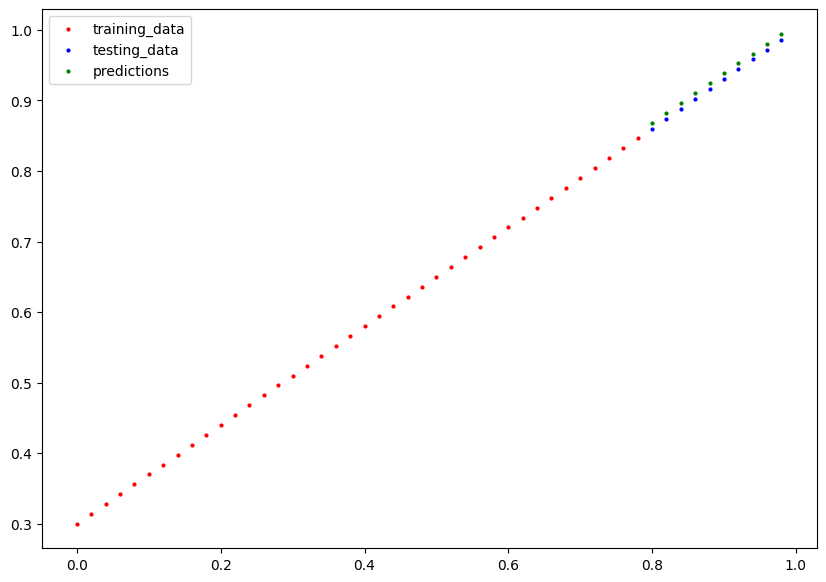

In [16]:
with torch.inference_mode():
    plot_model_data(X_train, y_train, X_test, y_test, predictions=y_preds)

In [17]:
# Turning tensors to arrays
loss_values = torch.tensor(loss_values).cpu().numpy()
test_loss_values = torch.tensor(test_loss_values).cpu().numpy()

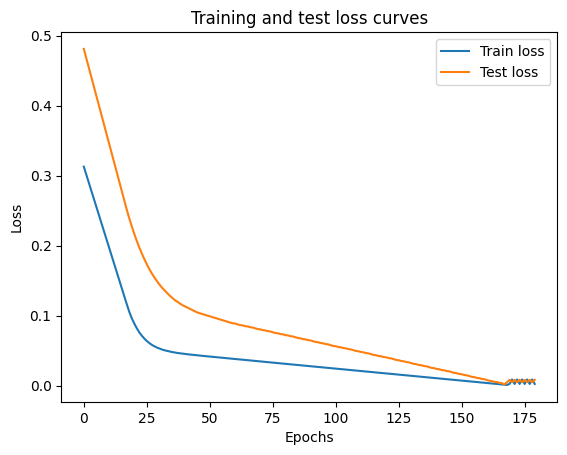

In [18]:
# Plotting loss curves
plt.plot(epoch_count, loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')

# Plot setup
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## 6- Saving and loading a model

[PyTorch saving and loading model](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html)


### 6.1- Saving a model

The main way of saving models in PyTorch `torch.save`, that allows saving a PyTorch object in Python's `pickle` format

PyTorch models have the extension `.pth` or `.pt`.

It's recommended to save the model's state dict instead of the whole model.


In [19]:
# Creating models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating model save path
MODEL_NAME = 'linear_regression_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/linear_regression_model.pth')

In [20]:
# Saving model state_dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

### 6.2- Loading a model

2 main methods for training and loading models in PyTorch:

1. `torch.load` - allows loading a saved PyTorch object.
2. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary (mostly for transfer learning).

We use the second one in casses where the saved data is not an entire model, but only its state dict (a Python dictionary that maps each layer to its parameter tensor). We do this by following these steps:

1. Instantiating the model that was used with the parameters
2. Loading the model save file with `torch.load()`.
3. Loading the state dict with the output of the previous step.


In [21]:
# Instantiating the original model
loaded_model = LinearRegressionModel()

# Loading the state dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
# Making predictions
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])